## Santiago González Quiroz  CC: 1040752831
## Clasificar pacientes ortopédicos en 2 clases (normal o anormal) por medio de las técnicas supervisadas de machine learning<font color="red"> árbol de clasificación y naves bayes. </font>



In [1]:
##Importar las librerias necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("max_columns",2000)
pd.set_option("max_rows",2000)

import seaborn as sb
from sklearn.metrics import pairwise_distances_argmin_min
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
%matplotlib inline

##tree grafica
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

plt.rcParams['figure.figsize'] = (15, 12)
plt.style.use('ggplot')


C:\Users\Gonza\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Carga del conjunto de datos:

In [2]:
df=pd.read_csv("columnavertebral.csv")

### Se observa un conjunto de datos con 310 registros y 7 columnas. 6 columnas como variables explicativas y una de respuesta.

In [3]:
print(df.shape)
df.head()

(310, 7)


,Incidencia_pelvica,inclinacion_pelvica,angulo_lordosis_lumbar,pendiente_sacra,radio_pelvis,espondilolistesis,tipo_paciente
0,63.03,22.55,39.61,40.48,98.67,-0.25,Anormal
1,39.06,10.06,25.02,"29,00",114.41,4.56,Anormal
2,68.83,22.22,50.09,46.61,105.99,-3.53,Anormal
3,69.3,24.65,44.31,44.64,101.87,11.21,Anormal
4,49.71,9.65,28.32,40.06,108.17,7.92,Anormal


### Se observan las variables explicativas: Incidencia_pelvica, inclinacion_pelvica, angulo_lordosis_lumbar, pendiente_sacra, radio_pelvis y espondilolistesis.

### Se verifican que la variable de respuesta tenga solo dos posibles valores, para descartar la presencia de otros valores como "norma" , "NORMAL", "Anorma" o cualquier variación de ambas palabras:


In [4]:
df["tipo_paciente"].value_counts()

Anormal    210
Normal     100
Name: tipo_paciente, dtype: int64

### Se decartaron otros posibles valores para la variable de respuesta, ya que se muestra que todos son "Normal" o "Anormal".

### La variable de respuesta está expresada de forma categórica como "Anormal" y "Normal", se llevan a una representación binaria 0 (normal) y 1 (anormal), usando un mapeo, qudando representada en una columna llamada respuesta.


In [5]:
df['respuesta'] =df['tipo_paciente'].map( {'Normal': 0, ##Mapeo para transformar los atributos.
                                        'Anormal': 1} ).astype(int) #0 -> Normal , 1-> Anormal
#try:
#    del df['tipo_paciente']
#except:
#    pass

### En un proceso de clasificación es importante contar con datos lo más balanceados posibles, por lo que se explora en el dataset para determinar si hay desbalanceo:

### * Cabe recordar que el total de datos son 310

In [6]:
df.groupby("respuesta").size() ##Número de muestras por cada valor de respuesta

##Datos de valor 1 -> Anormales.
print("Cantidad de datos clasificados como anormales: ",len(df[df.respuesta==1])/310*100, "%")
print("##################### ################### ##############")
print("Cantidad de datos clasificados como normales: ",len(df[df.respuesta==0])/310*100, "%")


Cantidad de datos clasificados como anormales:  67.74193548387096 %
##################### ################### ##############
Cantidad de datos clasificados como normales:  32.25806451612903 %


### Evidentemente los datos tienen un gran desbalance, donde la clase anormal tiene más del doble de datos que la clase normal:
   ### * Cantidad de datos clasificados como anormales:  67.74193548387096 %
   ### * Cantidad de datos clasificados como   normales:  32.25806451612903 %

### Antes de proceder a tratar el desbalanceo, se va a explorar el dataset para buscar errores, faltantes, patrones o cualquier caracteristica informante dentro de los datos: 

In [7]:
df.dtypes

Incidencia_pelvica        object
inclinacion_pelvica       object
angulo_lordosis_lumbar    object
pendiente_sacra           object
radio_pelvis              object
espondilolistesis         object
tipo_paciente             object
respuesta                  int32
dtype: object

### Vemos que buscando los tipos de cada columna, todas son te de tipo object, lo cual indica que hay presentes valores diferentes a númericos.

In [8]:
for variable in df.columns:
    print("VARIABLE: ",variable)
    print(df[variable].values)
    print("########## ##############3")

VARIABLE:  Incidencia_pelvica
['63.03' '39.06' '68.83' '69.3' '49.71' '40.25' '53.43' '45.37' '43.79'
 '36.69' '49.71' '31.23' '48.92' '53.57' '57.3' '44.32' '63.83' '31.28'
 '38.7' '41.73' '43.92' '54.92' '63.07' '45.54' '36.13' '54.12' '26.15'
 '43.58' '44.55' '66.88' '50.82' '46.39' '44.94' '38.66' '59.6' '31.48'
 '32.09' '35.7' '55.84' '52.42' '35.49' '46.44' '53.85' '66.29' '56.03'
 '50.91' '48.33' '41.35' '40.56' '41.77' '55.29' '74.43' '50.21' '30.15'
 '41.17' '47.66' '43.35' '46.86' '43.2' '48.11' '74.38' '89.68' '44.53'
 '77.69' '76.15' '83.93' '78.49' '75.65' '72.08' '58.6' '72.56' '86.9'
 '84.97' '55.51' '72.22' '70.22' '86.75' '58.78' '67.41' '47.74' '77.11'
 '74.01' '88.62' '81.1' '76.33' '45.44' '59.79' '44.91' '56.61' '71.19'
 '81.66' '70.95' '85.35' '58.1' '94.17' '57.52' '96.66' '74.72' '77.66'
 '58.52' '84.59' '79.94' '70.4' '49.78' '77.41' '65.01' '65.01' '78.43'
 '63.17' '68.61' '63.9' '85,00' '42.02' '69.76' '80.99' '129.83' '70.48'
 '86.04' '65.54' '60.75' '54.74'

### Se puede notar que los valores extraños presentes en el dataset, corresponden a números cuyo separador decimal es una "," y no el " . ". Por esto, pandas los toma como string y la variable pasa a ser tipo object. 
### Se muestran los registros por variable que presentan dicho problema: 


In [9]:
df[df.Incidencia_pelvica.str.contains(",")][["Incidencia_pelvica"]] ##Incidencia_pelvica

,Incidencia_pelvica
111,"85,00"
183,"71,00"
238,"69,00"
283,"49,00"


In [10]:
df[df.inclinacion_pelvica.str.contains(",")][["inclinacion_pelvica"]] ##Inclinación pelvica

,inclinacion_pelvica
34,"32,00"
127,"17,00"


In [11]:
df[df.angulo_lordosis_lumbar.str.contains(",")][["angulo_lordosis_lumbar"]].head(10) #angulo_lordosis_lumbar

,angulo_lordosis_lumbar
14,"47,00"
18,"31,00"
22,"54,00"
24,"29,00"
26,"14,00"
27,"47,00"
33,"40,00"
36,"36,00"
45,"47,00"
48,"34,00"


In [12]:
df[df.pendiente_sacra.str.contains(",")][["pendiente_sacra"]].head(10) #pendiente_sacra

,pendiente_sacra
1,"29,00"
38,"27,00"
107,"45,00"
119,"45,00"
131,"56,00"
222,"43,00"
225,"52,00"
239,"37,00"
256,"45,00"


In [13]:
df[df.radio_pelvis.str.contains(",")][["radio_pelvis"]].head(10) #radio_pelvis 

,radio_pelvis
8,"125,00"
173,"79,00"
200,"131,00"


In [14]:
df[df.espondilolistesis.str.contains(",")][["espondilolistesis"]].head(10) #espondilolistesis

,espondilolistesis
51,"5,00"
151,"35,00"
196,"56,00"
211,"2,00"


In [15]:
df[df.espondilolistesis.str.contains(",")][["espondilolistesis"]].head(10) #espondilolistesis

,espondilolistesis
51,"5,00"
151,"35,00"
196,"56,00"
211,"2,00"


### Se crea una función que reciba el dataframe y la columna que se quiere modificar, para aplicarle a cada registro de la columna un reemplazo de las "," por un ".". 

In [16]:
def convertir_comas(dataframe,serie): ##Función que reemplaza las comas por puntos en cada una de las columnas
    try:
        dataframe[serie]=dataframe[serie].str.replace(',','.').astype(np.float64)
    except:
        pass  ##Except para controlar cuando llegue a la columna que sí es números.
    return dataframe
    



In [17]:
for columna in df.columns:
    df=convertir_comas(df,columna)


### Se vuelve a mirar la descripción del dataset, donde ya se observan todas las variables de interés son de tipo float, por lo que el proceso de cambios de comas fue exitoso

In [18]:
print(df.dtypes)

Incidencia_pelvica        float64
inclinacion_pelvica       float64
angulo_lordosis_lumbar    float64
pendiente_sacra           float64
radio_pelvis              float64
espondilolistesis         float64
tipo_paciente              object
respuesta                   int32
dtype: object


### Se observa la descripción de los datos para buscar faltantes:

In [19]:
df.describe()

,Incidencia_pelvica,inclinacion_pelvica,angulo_lordosis_lumbar,pendiente_sacra,radio_pelvis,espondilolistesis,respuesta
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742,0.677419
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883,0.468220
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000,0.000000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000,0.000000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000,1.000000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000,1.000000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000,1.000000


### Se observa que no hay valores faltantes en el dataset, no hay que lidiar con NA entonces.

### Antes de tratar el tema del desbalanceo, se hace un análisis de correlaciones entre las variables explicativas, para análizar relación antes de balancear. 
### <font color="red"> Análisis de datos: </font>

### Este proceso es especialmente importante para hacer el clasificador mediante naive bayes, el cuál depende mucho de la relación o independecia entre variables y su distribución.
### Se usan los histogramas, scatter plot y matríz de pearson para observar las distribuciones y correlaciones:

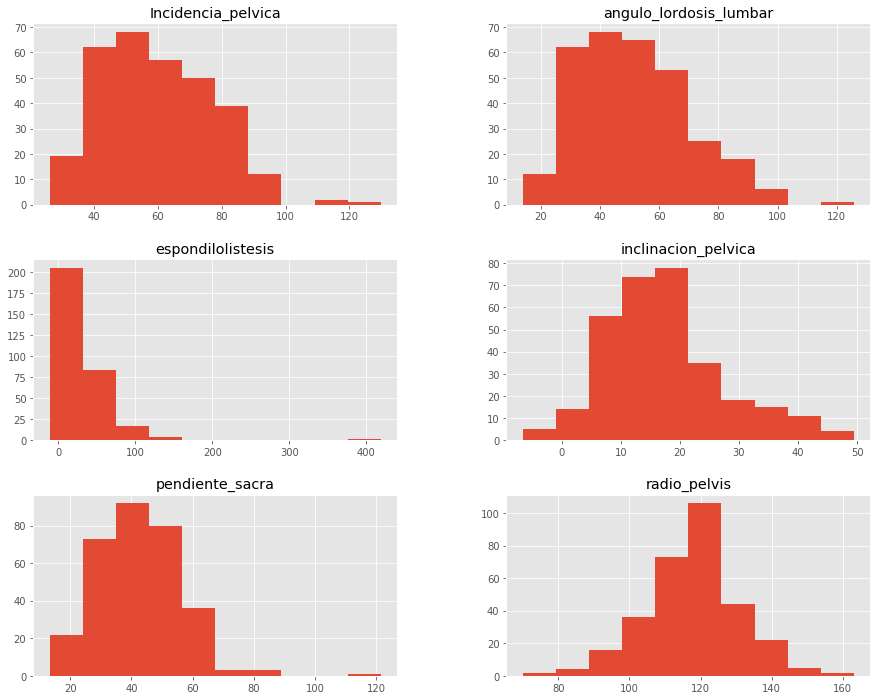

In [20]:
plt.rcParams['figure.figsize'] = (15, 12)
df.drop("respuesta",axis=1).hist( bins=10)
plt.show()

### Los gráficos indican que ninguna variable se distribuye completamente normal, pero sí hay algunas con tendencia a la normalidad:
### * Inclinación_pelvica, radio_pelvis, 
### * pendiente_sacra. 
### Las demás no están tan alejadas, pero sí son menos parecidas a una normal.

### Parece que trabajar asumiendo que todas se distribuyen normalmente no es mala idea.


C:\Users\Gonza\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


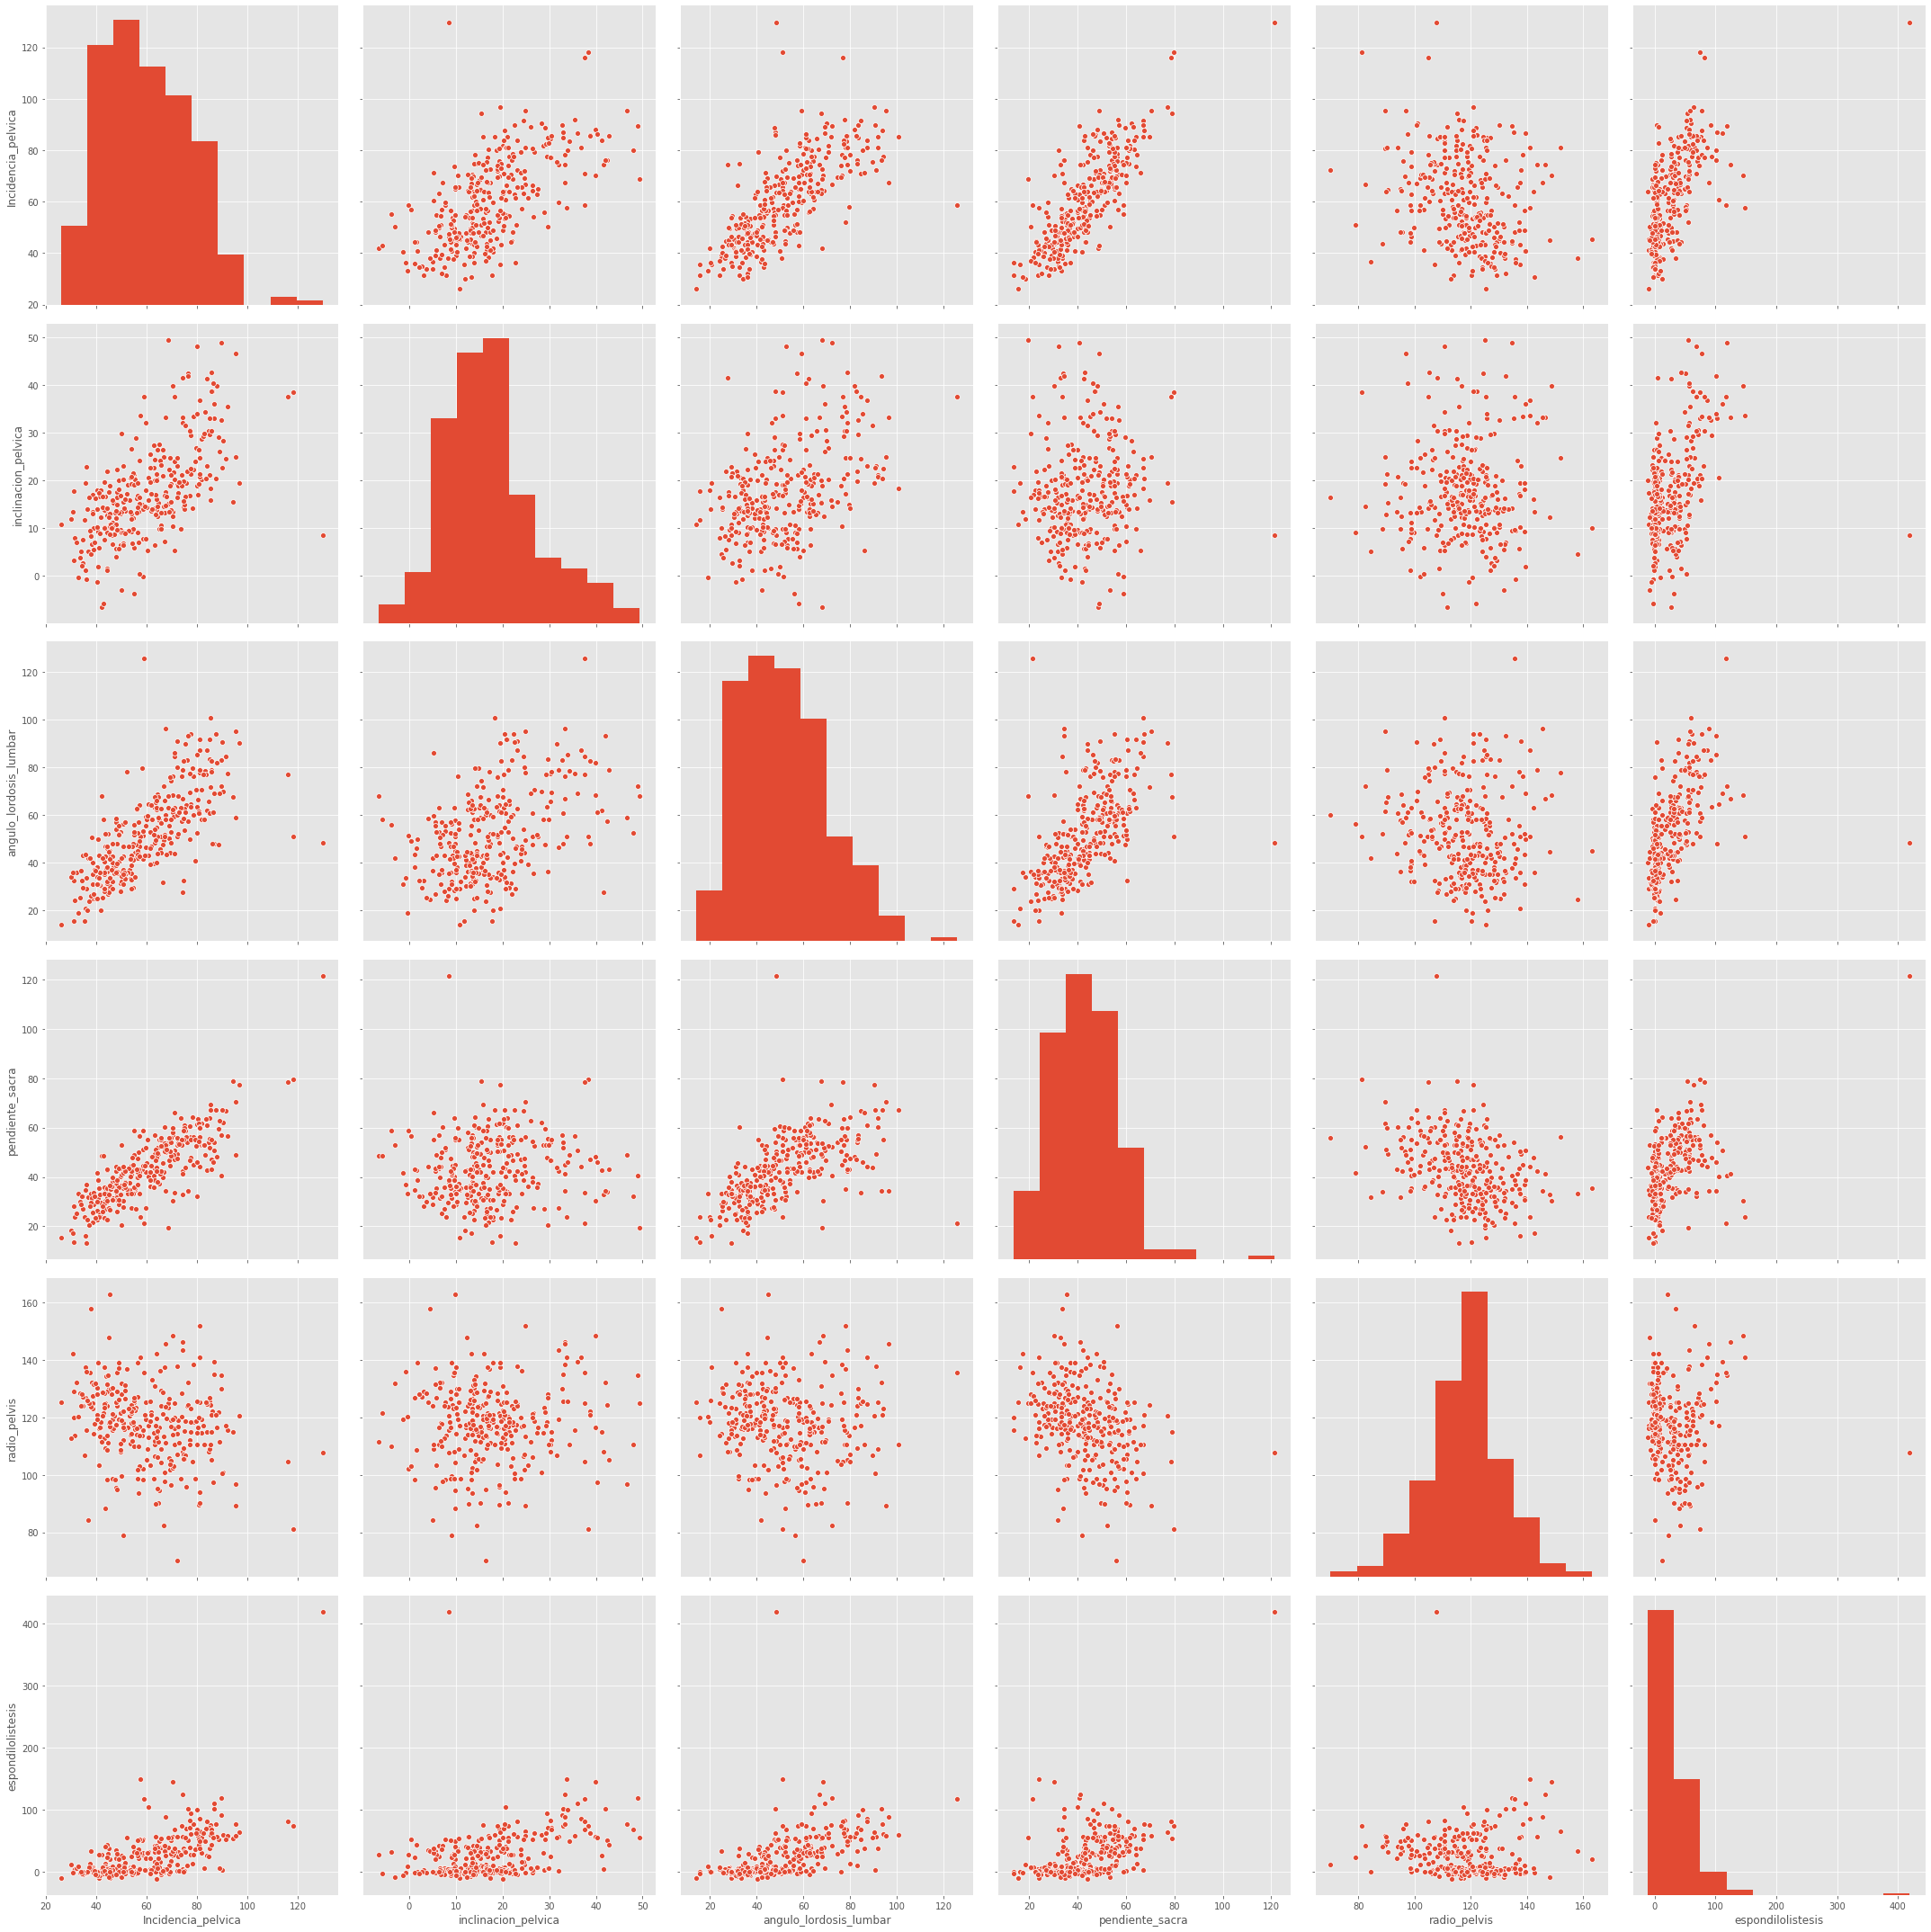

In [21]:
sb.pairplot(df,size=5,vars=['Incidencia_pelvica','inclinacion_pelvica','angulo_lordosis_lumbar','pendiente_sacra','radio_pelvis','espondilolistesis'],kind='scatter') ##Grafica con base en 3 variables.


### Se debe tener especial cuidado con el factor de las correlaciones, pues la premisa más importante que tiene el naive bayes, es la independencia entre los features. Se analizan a fondo los coeficientes:

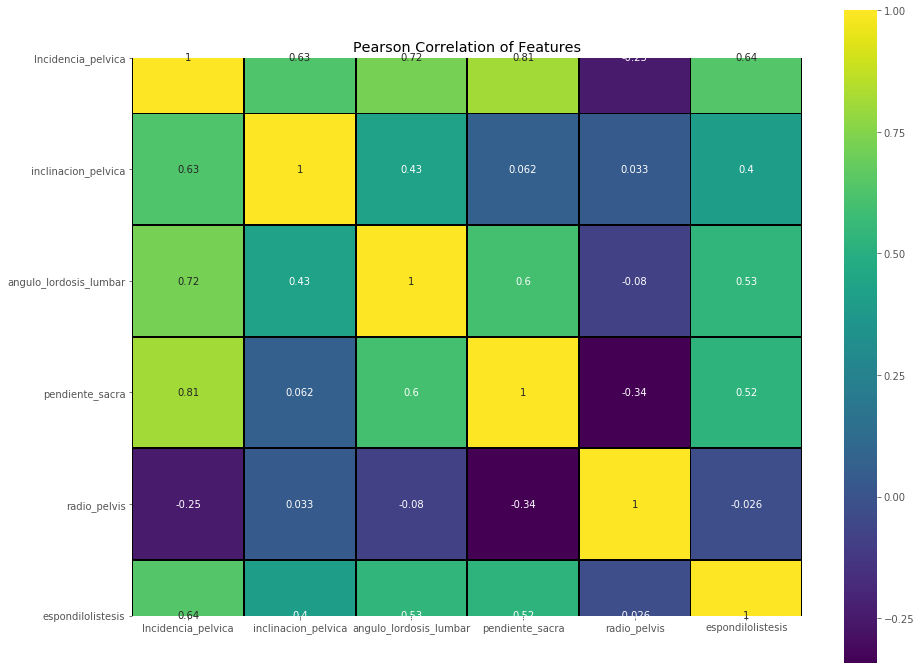

In [22]:
plt.rcParams['figure.figsize'] = (15, 12)
colormap = plt.cm.viridis  #Correlación de Pearson
#plt.figure(figsize=(13,13))
plt.title('Pearson Correlation of Features')
sb.heatmap(df.drop("respuesta",axis=1).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.8,
           linecolor='black',
           square=True)

### Solo hay un par de variables que están peligrosamente correlacionadas para el modelo, son: Incidencia_pelvica y pendiente_ sacra. (0.81)

### Cabe recordar que estas dos son de las que más "normalmente" se distribuyen. Qué hacer? 

### Borrar alguna de las dos ( la que menos normal parezca)? Para tomar una decisión de estas, lo mejor es ponerse en el contexto de los datos, por lo que es necesario consultar en fuentes externas qué significan estas dos variables:
 ### * https://neurorgs.net/docencia/sesiones-residentes/balance-sagital-una-introduccion-teorica/ dice:
 ### <font color="blue"> "...La relación entre la PI (incidencia pelvica) y el SS (pendiente sacra) se ha demostrado en diferentes estudios, correlacionándose con SS (r = 0,80) ..."</font>. Curiosamente se tiene un índice de correlación de 0,81 , lo que concuerda con la fuente citada. 
 ### Dada esta alta correlación para el clasificador naive bayes, se dejará por fuera la variable pendiente_sacra y se tomará la incidencia pelvica.



### <font color="red"><h1> Desbalanceo de datos:</h1> </font>
### Se puede proceder a tratar el desbalanceo de los datos. Para tratar este problema existen varios enfoques, entre ellos:
   ### 1. Remuestrear la clase minoritaria (0) Normal
   ### 2. Submuestrear la clase mayoritaria (1) Anormal
   ### 3.  Aclararle al algoritmo de clasificación que hay desbalanceo para que penalice
   ### 4.  Generar muestras sinteticas
   
 ## <font color="blue"> Descartadas: </font>
   
### La opción número 1 se descarta porque al remuestrear la clase minoritaría al doble de su tamaño (para igualar las cantidades), quedaría con demasiada información duplicada.

### La opción número 2 se descarta porque al hacer un submuestreo de la clase mayoritaría, dejandola con igual cantidad de muestras que la minoritaria, el conjunto total quedaría solo con 200 datos, lo cual es verdaderamente poco. Además en los 110 registros que estaría sacando de la clase mayoritaría, se estaría perdiendo mucha información
## <font color="blue">Opciones a probar:</font>
   ### La opción número 3 y número 4 se van a probar, en ambos tipos de clasificadores que se van a usar (árbol de clasificación y bayesiano), para mirar las diferencias.

    

### <font color="red"> HACER MUESTRAS SINTETICAS DE LA CLASE MINORITARIA: </font>
### Estas muestras deben hacerse después de haber partido los datos en el conjunto de test y de entrenamiento, para tratar de evitar el sobreajuste del modelo. El particionamiento de los datos se hizo con 75% para train y 25% para test

#### Para hacer esto, se usó la librería  imblearn’s con su función de SMOTE, la cual a través de método de K-vecinos más cercanos, sobremuestrea la clase minoritaria (https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

In [23]:
#Obtener los datos explicativos y target
y = df.respuesta ##variable target
X = df.drop(['respuesta',"tipo_paciente"], axis=1) ##explicativas
columnas=X.columns


In [24]:
##Separar los conjuntos de test y de train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42222)

### Cómo quedaron los datos después de particionar?

In [25]:
print("Valores para entrenar ",y_train.value_counts())
print("Valores para probar",y_test.value_counts())

Valores para entrenar  1    161
0     71
Name: respuesta, dtype: int64
Valores para probar 1    49
0    29
Name: respuesta, dtype: int64


### En entrenamiento se obtuvo 161 muestras clase 1 y 49 muestras clase 0.
## Se proceden a generar las muestras sinteticas:

In [26]:
sm = SMOTE(random_state=327, ratio=1.0) ##Crearmos objeto smote
X_train, y_train = sm.fit_sample(X_train, y_train) ##Se ajusta el modelo smote a los datos de entrenamiento

In [27]:
newy=pd.Series(y_train)  ## Se pone como serie para ver los resultados del smote
newy.value_counts()

1    161
0    161
dtype: int64

### * Se puede notar como a través de smote, se igualó el número de muestras de la clase minoritaría con registros sinteticos. Ambas quedaron con 161 registros.

### * Se puede proceder  llamar los modelos de árbol de decisión y clasificación bayesiana para evaluar desempeño:

### <font color="blue"> Árbol de clasificación: </font>

### * No se le indica que balancee las clases porque ya están balanceadas. Se prueban varios niveles de profundidad. Se seleccionó el criterio de entropía. La anterior selección fue hecha después de haber probado manualmente varias posibilidades y se observó que con entropía y los valores mencionados, se logra mayor precisión.

### * Se acomoda el min_samples_split a algo que tenga sentido con la cantidad de datos que tengo para entrenar (306)

### Se itera sobre un rango de niveles de profunidad para buscar el más óptimo:


In [28]:
##Entropía
for i in range(1,9):
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                                 min_samples_split=10,
                                                 min_samples_leaf=8,
                                                 max_depth = i)

    tree_model.fit(X_train,y_train)
    preddicionxtest=tree_model.predict(X_test)
    print("PROFUNDIDAD: ",i)
    print("Precision",accuracy_score(y_test, preddicionxtest))
    print("Recall",recall_score(y_test, preddicionxtest))
    print("############################################################")


## 10,8,6  -> Precision 0.8461538461538461
            #recall 0.8421052631578947

PROFUNDIDAD:  1
Precision 0.8717948717948718
Recall 0.8163265306122449
############################################################
PROFUNDIDAD:  2
Precision 0.8717948717948718
Recall 0.8163265306122449
############################################################
PROFUNDIDAD:  3
Precision 0.8589743589743589
Recall 0.8367346938775511
############################################################
PROFUNDIDAD:  4
Precision 0.8717948717948718
Recall 0.8775510204081632
############################################################
PROFUNDIDAD:  5
Precision 0.8589743589743589
Recall 0.8775510204081632
############################################################
PROFUNDIDAD:  6
Precision 0.8589743589743589
Recall 0.8775510204081632
############################################################
PROFUNDIDAD:  7
Precision 0.8589743589743589
Recall 0.8775510204081632
############################################################
PROFUNDIDAD:  8
Precision 0.8333333333333334
Recall 0.8775510204081632
#####

## Se evidencia que con 6 niveles de profundidad se obtiene el mejor precision y recall de todos los que se probaron. Se toma este árbol y se analiza más a fondo:

In [29]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                                 min_samples_split=10,
                                                 min_samples_leaf=8,
                                                 max_depth = 6)

tree_model.fit(X_train,y_train)
preddicionxtest=tree_model.predict(X_test)

        

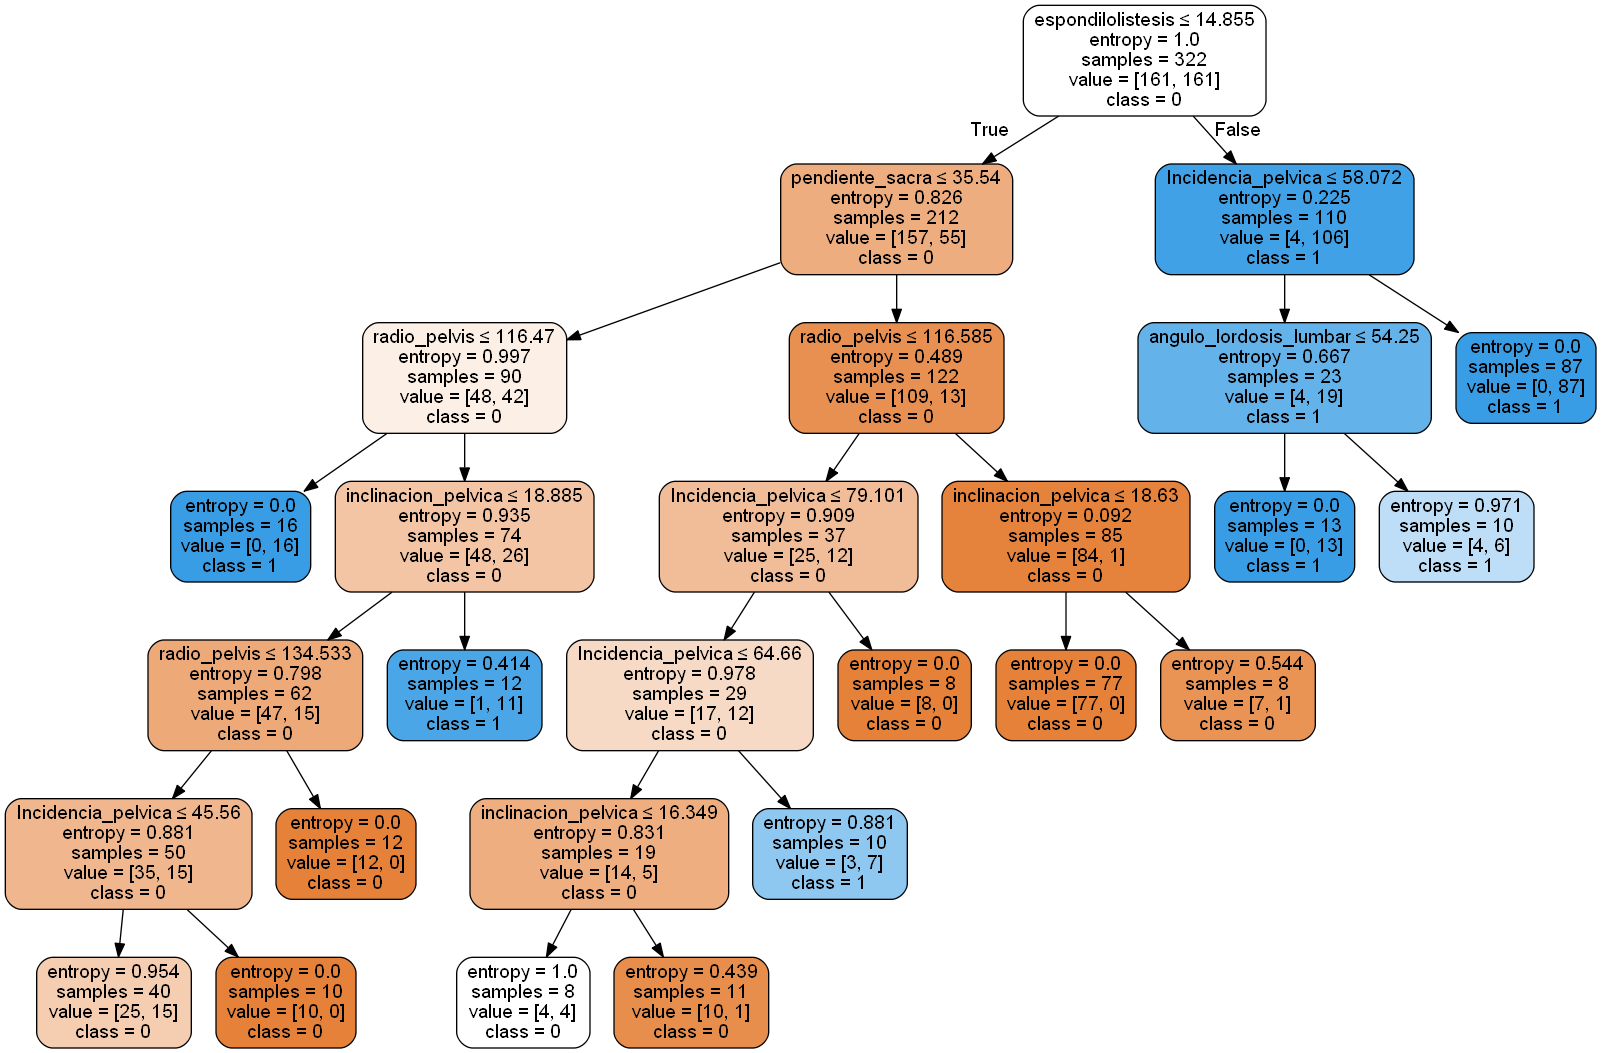

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_model, max_depth=6, out_file=dot_data,  
                filled=True, rounded=True,impurity = True,
                special_characters=True,feature_names = columnas,
               class_names = ["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Se observa la matríz de confusión:

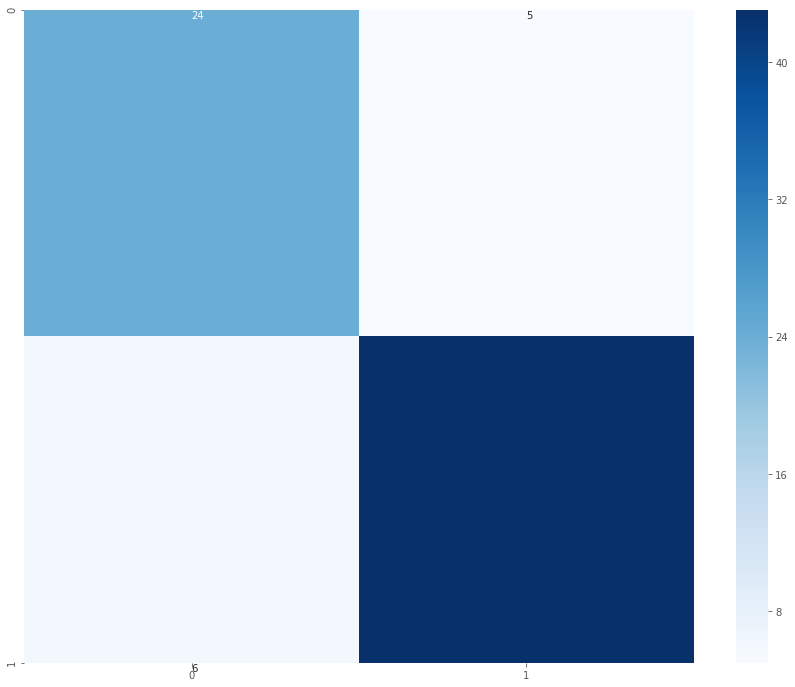

In [31]:
mat_rgl=metrics.confusion_matrix(y_test, preddicionxtest)
ax1=plt.axes()

annot_kws = {"ha": 'left',"va": 'top'}
sb.heatmap(mat_rgl, square=False, annot=True,cbar=True,cmap="Blues", annot_kws=annot_kws, ax=ax1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('dark_background')
plt.show()

## Se muestra la curva ROC del modelo:

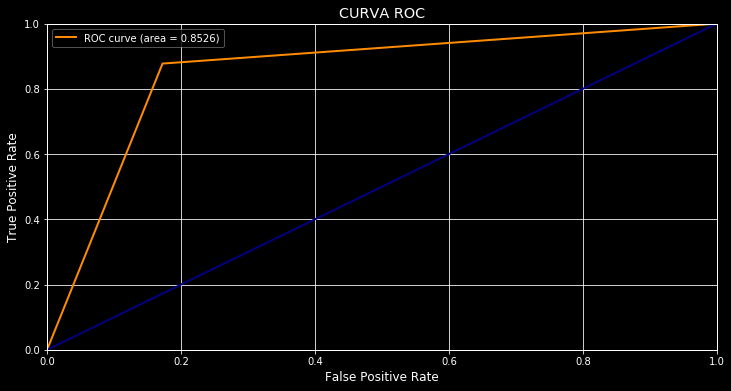

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, preddicionxtest)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CURVA ROC')
plt.legend(loc="upper left")
plt.style.use('dark_background')
plt.show()

### * El modelo de árbol de clasificación con muestreo sintetico para tratar el desbalanceo nos da una ROC de 0.85

### Probando predicción: 

In [33]:
print("Clasificador: ",tree_model.predict(X.loc[0].to_numpy().reshape(1,-1)))
print("Real: ",y.loc[0])

Clasificador:  [0]
Real:  1


### <font color="blue"> Naive bayes: </font>

### Recordar que para este modelo se deja por fuera la variable pendiente_sacra.

In [34]:
#Obtener los datos explicativos y target
y = df.respuesta ##variable target
X = df.drop(['respuesta',"tipo_paciente", "pendiente_sacra"], axis=1) ##explicativas, sin pendiente sacra
##Separar los conjuntos de test y de train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42222)


### Nuevamente se deja en evidencia el balanceo que se hace por medio de smote para obtener el número de muestras en el conjunto de entrenamiento.

In [35]:
print("Valores para entrenar ",y_train.value_counts())
print("Valores para probar",y_test.value_counts())

Valores para entrenar  1    161
0     71
Name: respuesta, dtype: int64
Valores para probar 1    49
0    29
Name: respuesta, dtype: int64


In [36]:
sm = SMOTE(random_state=37, ratio=1.0) ##Crearmos objeto smote
X_train, y_train = sm.fit_sample(X_train, y_train) ##Se ajusta el modelo smote a los datos de entrenamiento
newy=pd.Series(y_train)  ## Se pone como serie para ver los resultados del smote
newy.value_counts()

1    161
0    161
dtype: int64

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
# Crear clasificador
gnbbalanced = GaussianNB()



In [38]:
gnbbalanced.fit(X_train,y_train) #entrenarlo en train
xtestpredicho = gnbbalanced.predict(X_test) #predecir en test


### Se muestra la matríz de confusión para el modelo:

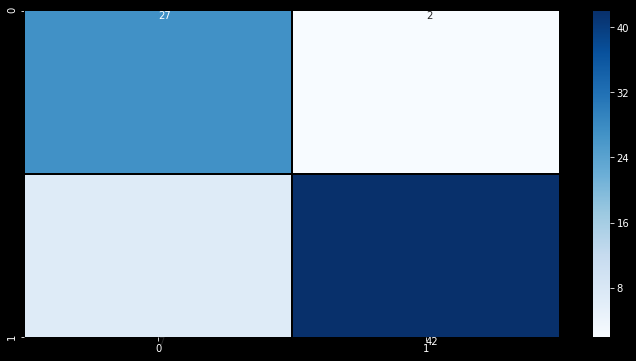

In [39]:
mat_rgl=metrics.confusion_matrix(y_test,xtestpredicho)
ax1=plt.axes()
annot_kws = {"ha": 'left',"va": 'top'}
plt.rcParams['figure.figsize'] = (12, 6)
sb.heatmap(mat_rgl, square=False, annot=True,cbar=True,cmap="Blues", ax=ax1,annot_kws=annot_kws, linewidths=0.8,
           linecolor='black')

plt.style.use('dark_background')
plt.show()

### Se muestra la curva ROC para el modelo: 

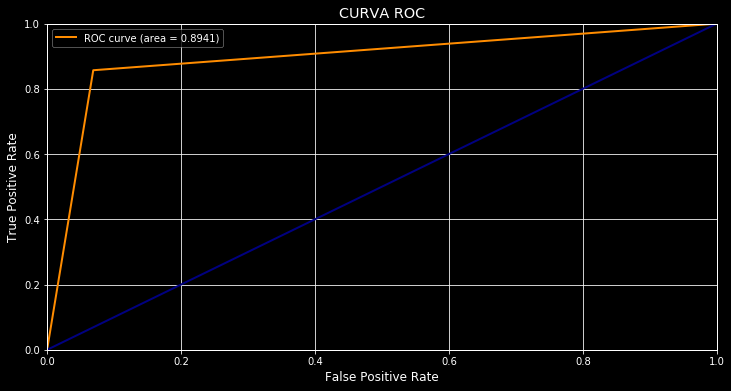

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, xtestpredicho)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CURVA ROC')
plt.legend(loc="upper left")
plt.style.use('dark_background')
plt.show()

### * El modelo naive bayes con muestreo sintetico para tratar el desbalanceo da una ROC de 0.89

### Probando predicción:

In [41]:
print("Clasificador: ",gnbbalanced.predict(X.loc[0].to_numpy().reshape(1,-1)))
print("Real: ",y.loc[0])

Clasificador:  [1]
Real:  1


In [42]:
##Naive bayes gausiana se usa cuando x tiene valores continuos y no categoricos.
##Asume que todos los feaures son independientes
##Asume que las variables se distribuyen normalmente.
#Si ambas cosas pasan, es mucho mejor el clasificador.

### <font color= "red" > Aclararle al algoritmo de clasificación que hay desbalanceo para que penalice</font>

### Este método es más fácil de trabajar, ya que es más directo. Simplemente se parte el conjunto de datos y se llaman los respectivos algoritmos de clasificación, aclarando el desbalance en uno de los hiperparametros.

In [43]:
#Obtener los datos explicativos y target
y = df.respuesta ##variable target
X = df.drop(['respuesta',"tipo_paciente"], axis=1) ##explicativas


In [44]:
##Separar los conjuntos de test y de train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### <font color="blue"> Árbol de clasificación: <font>

### Se usará un enfoque similar al usado con las muestras sinteticas. Se tratarán de usar los mismos hiperparametros (con expceción del class balanced) y se iterara sobre las distintas profunidades del árbol:



### Con entropía: 

In [45]:
for i in range(1,12):
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                                 min_samples_split=10,
                                                 min_samples_leaf=8,
                                                 max_depth = i, class_weight="balanced")

    tree_model.fit(X_train,y_train)
    preddicionxtest=tree_model.predict(X_test)
    print("PROFUNDIDAD: ",i)
    print("Precision",accuracy_score(y_test, preddicionxtest))
    print("Recall",recall_score(y_test, preddicionxtest))
    print("############################################################")

PROFUNDIDAD:  1
Precision 0.7692307692307693
Recall 0.6842105263157895
############################################################
PROFUNDIDAD:  2
Precision 0.7948717948717948
Recall 0.8070175438596491
############################################################
PROFUNDIDAD:  3
Precision 0.7692307692307693
Recall 0.7192982456140351
############################################################
PROFUNDIDAD:  4
Precision 0.7692307692307693
Recall 0.7543859649122807
############################################################
PROFUNDIDAD:  5
Precision 0.7692307692307693
Recall 0.7543859649122807
############################################################
PROFUNDIDAD:  6
Precision 0.7692307692307693
Recall 0.7719298245614035
############################################################
PROFUNDIDAD:  7
Precision 0.7692307692307693
Recall 0.7719298245614035
############################################################
PROFUNDIDAD:  8
Precision 0.7692307692307693
Recall 0.7719298245614035
#####

### Con gini:

In [46]:
##gini
###Por entropía se vio que no es efectivo, se prueba entonces el gini.
for i in range(1,12):
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                                 min_samples_split=10,
                                                 min_samples_leaf=8,
                                                 max_depth = i, class_weight="balanced")

    tree_model.fit(X_train,y_train)
    preddicionxtest=tree_model.predict(X_test)
    print("PROFUNDIDAD: ",i)
    print("Precision",accuracy_score(y_test, preddicionxtest))
    print("Recall",recall_score(y_test, preddicionxtest))
    print("############################################################")

PROFUNDIDAD:  1
Precision 0.7692307692307693
Recall 0.6842105263157895
############################################################
PROFUNDIDAD:  2
Precision 0.7948717948717948
Recall 0.8070175438596491
############################################################
PROFUNDIDAD:  3
Precision 0.7307692307692307
Recall 0.7719298245614035
############################################################
PROFUNDIDAD:  4
Precision 0.7948717948717948
Recall 0.8070175438596491
############################################################
PROFUNDIDAD:  5
Precision 0.7948717948717948
Recall 0.8421052631578947
############################################################
PROFUNDIDAD:  6
Precision 0.8205128205128205
Recall 0.8421052631578947
############################################################
PROFUNDIDAD:  7
Precision 0.7564102564102564
Recall 0.7894736842105263
############################################################
PROFUNDIDAD:  8
Precision 0.7948717948717948
Recall 0.8421052631578947
#####

### Parece ser que con una profundidad de 8 y tomando la métrica gini, se tiene un buen precisition y recall, se decide tomar este arbol y explorar más a fondo:

In [47]:
tree_modelbalanced = tree.DecisionTreeClassifier(criterion='gini',
                                                 min_samples_split=10,
                                                 min_samples_leaf=8,
                                                 max_depth = 8, class_weight="balanced", random_state=42)

tree_modelbalanced.fit(X_train,y_train)
preddicionxtest=tree_modelbalanced.predict(X_test)

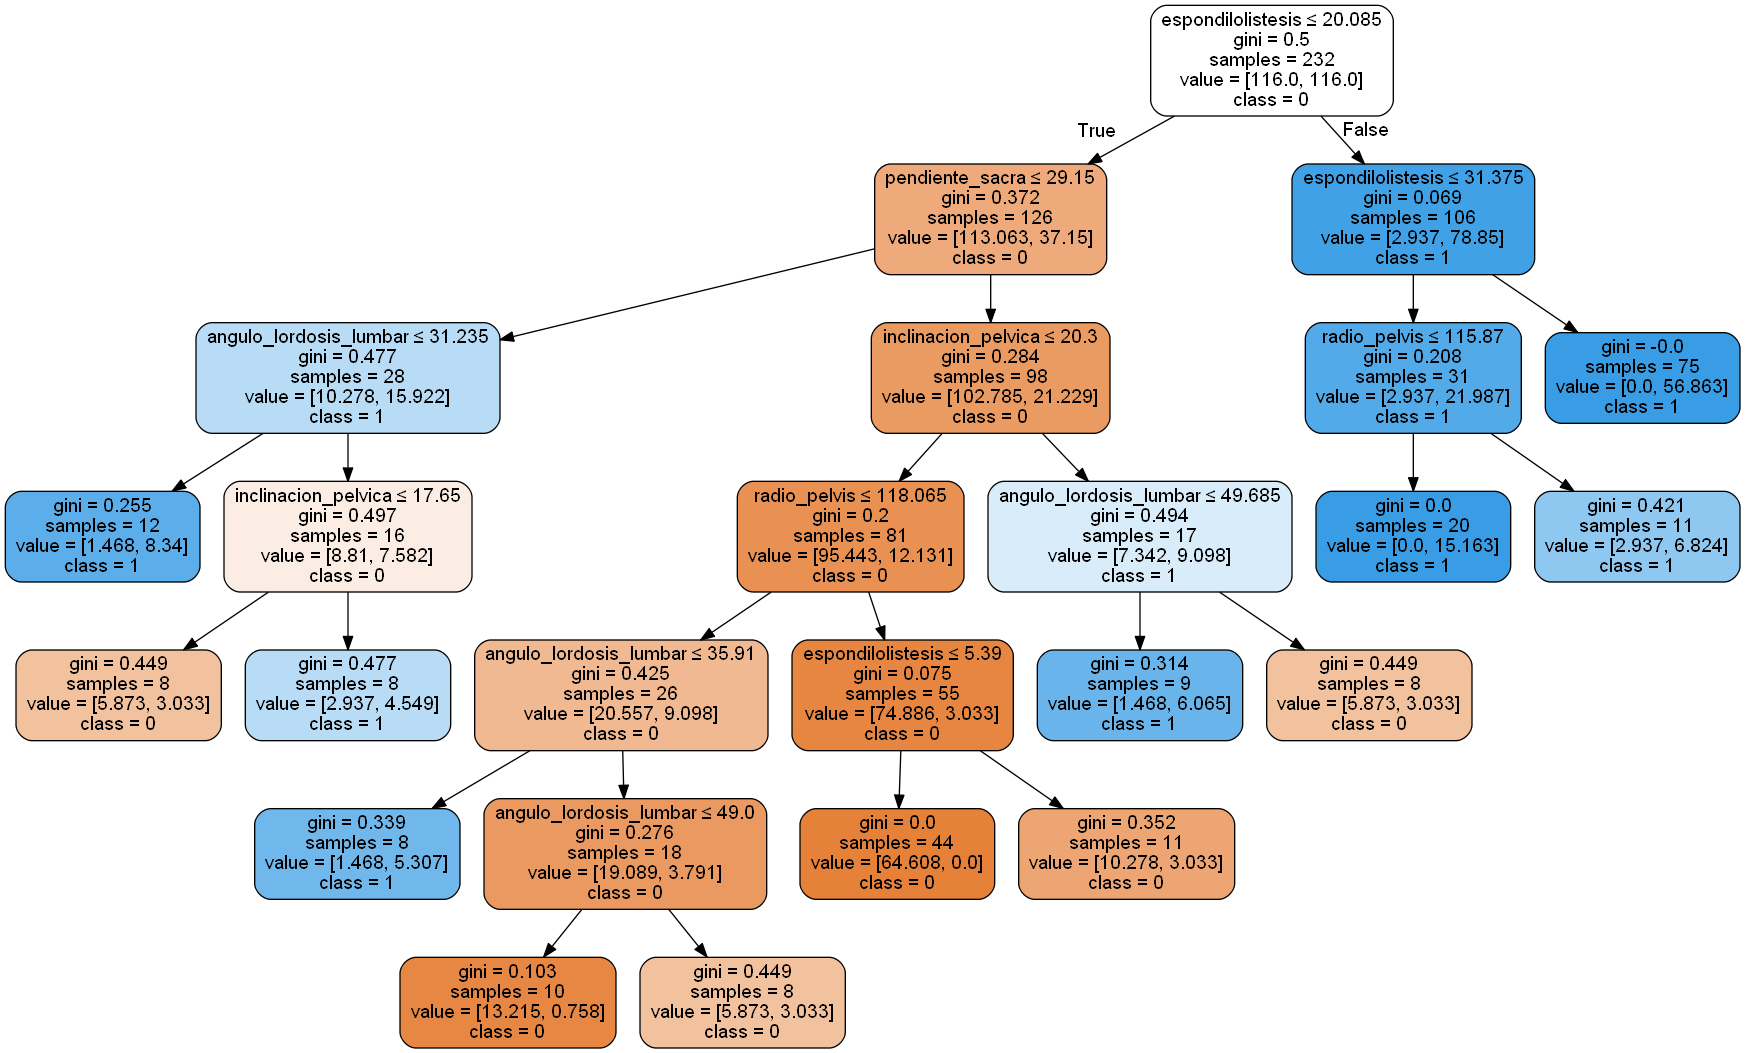

In [48]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_modelbalanced, max_depth=8, out_file=dot_data,  
                filled=True, rounded=True,impurity = True,
                special_characters=True,feature_names =columnas,
               class_names = ["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Matríz de confusíon:

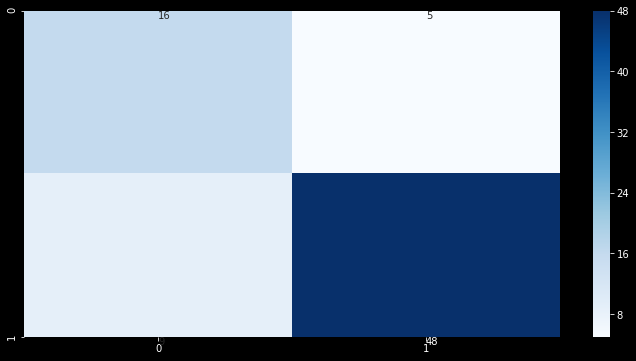

In [49]:
mat_rgl=metrics.confusion_matrix(y_test, preddicionxtest)
ax1=plt.axes()
plt.rcParams['figure.figsize'] = (12, 6)
annot_kws = {"ha": 'left',"va": 'top'}
sb.heatmap(mat_rgl, square=False, annot=True,cbar=True,cmap="Blues",annot_kws=annot_kws, ax=ax1)

plt.style.use('dark_background')
plt.show()

### Curva roc:

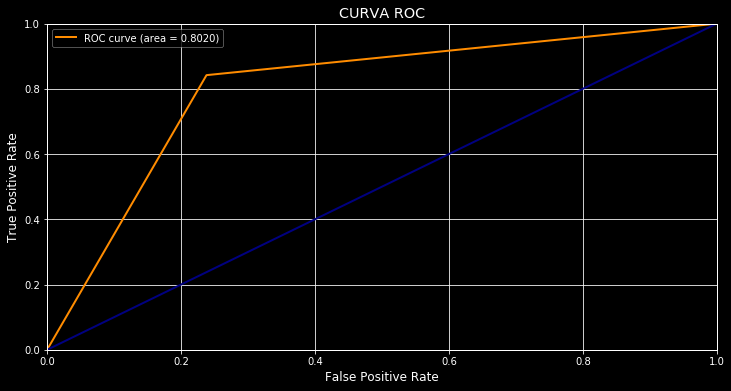

In [50]:

fpr, tpr, thresholds = roc_curve(y_test, preddicionxtest)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CURVA ROC')
plt.legend(loc="upper left")
plt.style.use('dark_background')
plt.show()

### Con el árbol de clasificación, añadiendole el parametro de clases desbalanceadas, se obtuvo una roc de 0.80

### Probando una predicción:

In [51]:
print("Clasificador: ",tree_modelbalanced.predict(X.loc[0].to_numpy().reshape(1,-1)))
print("Real: ",y.loc[0])

Clasificador:  [1]
Real:  1
